# Using text classification to examine lyric sentiment

The great songs make us *feel*. Joy. Elation. Danger. Extreme feelings often occur in the same song (*soon* by mbv anyone?).

The real power lies in the congurance between music and lyrics.

For example, the opening lyric of *Blue* by Joni Mitchell is "Blue" accompanied by a minor chord. Minor chords evoke negative feelings (i.e. sadness). Thus the utterance of the word blue feels...really blue. Just imagine if it were played with a major chord instead? A negative word contrasted with chords that evoke positive feelings.

<!--TBC: something about intervals here.-->

To that end, I will evaluate the effectiveness of text classification methods of classifying lyrics as *positive*, *neutral* and *negative*. I will compare the effectiveness of a supervised learning approach (Naive Bayes) to a deep learning approaches (Zero-Shot classification, NLP Prompt using Chat GPT).

For further information on the importance of intervals and emotions:

* [Gravity Sound](https://gravitysound.studio/blogs/news/how-interval-music-theory-can-trick-your-brain)
* [How Music Really Works](https://www.howmusicreallyworks.com/chapter-four-scales-intervals/intervals-emotional-power-music.html)


In [1]:
#Import libraries and packages
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import re
import torch
from transformers import pipeline

In [ ]:
#Read data using chunks

file_path = 'song_lyrics.csv'

chunk_size = 100000

chunks = []

for chunk in pd.read_csv(file_path, chunksize=chunk_size):

    chunks.append(chunk)

# Concatenate all chunks into a single DataFrame if needed
song_lyrics_full_df = pd.concat(chunks, ignore_index=True)

### Data preprocessing

In preparation for text classification, we will filter our data based on the findings from our EDA:

* Keep tracks with English lyrics.
* Remove artists which contain the word "Genius"
* Remove tracks under the "misc" genre.
* Keep songs since 1880, the dawn of popular music.
* Remove songs after 2022, the year this dataset "ends".
* Keep songs with at least 448 views (i.e. top 25% of tracks).

We also need to clean the lyrics. This involves removing text between the square brackets, such as section markers, song credits, features, and apply standard cleaning processes. This will enable text classification to be more effective. We can use the lyrics to *Wish You Were Here* to show the impact of cleaning the lyrics.

TODO: need to check the character length of the lyrics - are they longer than the max?

TODO: remove songs with a low number of views? Do a histogram of views? We want to learn from well known songs.


In [ ]:
#Data Preprocessing
import re

#Clean text
def clean_lyrics(text):
    
    #Remove text between brackets
    text = re.sub(r'\[.*?\]', '', text)
    
    # Remove newline and tab characters
    text = re.sub(r'[\n\t]', ' ', text)
    
    # Remove special characters and digits (optional, depending on use case)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Convert to lowercase
    text = text.lower()
    
    return text

# Example usage of cleaning lyrics to wish you were here
#wish_you_were_here_clean = clean_lyrics(wish_you_were_here_df.iloc[0,6])
#display(wish_you_were_here_clean)


In [ ]:
#Undertake data cleaning
song_lyrics_clean_df = song_lyrics_full_df.copy()

#Filter data for english lyrics
song_lyrics_clean_df = song_lyrics_clean_df[(song_lyrics_clean_df['language'] == 'en')]

#Filter data to remove artists containing "Genius"
song_lyrics_clean_df  = song_lyrics_clean_df [~song_lyrics_clean_df ['artist'].str.contains('Genius', case=False, na=False)]

#Filter for data between 1880 and 2022
song_lyrics_clean_df = song_lyrics_clean_df[(song_lyrics_clean_df['year'] >= 1880) & (song_lyrics_clean_df['year'] <= 2022)]

#Filter for songs with more than 448 views - so only the top 25% of lyrics.
song_lyrics_clean_df = song_lyrics_clean_df[(song_lyrics_clean_df['views'] >= 448)]

#Filter data for misc genre
song_lyrics_clean_df = song_lyrics_clean_df[~(song_lyrics_clean_df['tag'] == 'misc')]

#Clean text
song_lyrics_clean_df['lyrics'] = song_lyrics_clean_df['lyrics'].apply(clean_lyrics)

# Drop unecessary columns
song_lyrics_clean_df = song_lyrics_clean_df.drop(columns=['id','language_cld3','language_ft'])


### Sampling the data

Assumption for a getting sample for the text classification problem - too long to run analysis on everything

In [ ]:
import pandas as pd

#Write df to csv
#song_lyrics_clean_df.to_csv("song_lyrics_clean_df.csv")

song_lyrics_clean_df = pd.read_csv("song_lyrics_clean_df.csv")

# Desired total sample size
total_sample_size = 2000

# Calculate the number of rows in each category
genre_counts = song_lyrics_clean_df['tag'].value_counts()

# Calculate the sample size for each category
stratified_sample_sizes = (genre_counts / genre_counts.sum() * total_sample_size).round().astype(int)

# Perform stratified sampling
song_lyrics_clean_sample_df = song_lyrics_clean_df.groupby('tag').apply(lambda x: x.sample(stratified_sample_sizes.loc[x.name], random_state=1)).reset_index(drop=True)

#Save output to csv
song_lyrics_clean_sample_df.to_csv('song_lyrics_clean_sample.csv')



## Which songs evoke positive, negative or neutral feelings?

### Zero-shot Classification

Commentary TBC
<!--write something about using zero shot classification 
Write about testing it on Wish You Were HEre
Write about the results - what do they broadly say about lyrics?
Also note issues - i.e. thunderstruck
https://huggingface.co/tasks/zero-shot-classification
https://huggingface.co/facebook/bart-large-mnli
https://huggingface.co/datasets/nyu-mll/multi_nli
-->

In [ ]:
# Developing the zero-shot model
import torch
from transformers import pipeline

#Added to ensure that it uses the apple M1 cores.
#https://github.com/jeffheaton/app_deep_learning/blob/main/install/pytorch-install-aug-2023.ipynb
has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
#device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize the zero-shot classification pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli",device=device)


In [ ]:
# Define candidate labels
sentiment_labels = ["positive","neutral","negative"]

#Lyrics
song_df = song_lyrics_clean_df[(song_lyrics_clean_df['artist'] == "Pink Floyd") & (song_lyrics_clean_df['title'] == "Wish You Were Here")]
song_lyrics = song_df.iloc[0,6]

# Perform zero-shot classification
sentiment_result = classifier(song_lyrics, sentiment_labels)

#Sentiment results
print("Sentiment Labels:", sentiment_labels)
print("Classification Result:", sentiment_result)


In [ ]:
#Create dataset for zero shot results
song_lyrics_zero_shot_df = song_lyrics_clean_sample_df.copy()

#Sentiment labels
sentiment_labels = ["positive","neutral","negative"]

# Function to classify text and store results
def classify_lyrics(lyrics, candidate_labels):
    result = classifier(lyrics, candidate_labels)
    return result

# Apply classification to each row and store results
song_lyrics_zero_shot_df['classification'] = song_lyrics_zero_shot_df['lyrics'].apply(lambda x: classify_lyrics(x, sentiment_labels))

# Extract the scores for each label
for label in sentiment_labels:
    song_lyrics_zero_shot_df[label] = song_lyrics_zero_shot_df['classification'].apply(lambda x: x['scores'][x['labels'].index(label)])

# Extract the predicted label and score
song_lyrics_zero_shot_df['predicted_label'] = song_lyrics_zero_shot_df['classification'].apply(lambda x: x['labels'][0])
song_lyrics_zero_shot_df['predicted_score'] = song_lyrics_zero_shot_df['classification'].apply(lambda x: x['scores'][0])

# Drop the intermediate 'Classification' column
song_lyrics_zero_shot_df = song_lyrics_zero_shot_df.drop(columns=['classification'])




In [ ]:
#Write results to csv
#song_lyrics_zero_shot_df.to_csv('song_lyrics_zero_shot_df.csv')

#Load zero shot results
song_lyrics_zero_shot_df = pd.read_csv('song_lyrics_zero_shot_df.csv')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

#Display table of results
song_lyrics_zero_shot_summary_df = song_lyrics_zero_shot_df.groupby('predicted_label').agg({'artist':'count'}).reset_index()
song_lyrics_zero_shot_summary_df = song_lyrics_zero_shot_summary_df.rename(columns = {"artist" : "number of predictions"})
display(song_lyrics_zero_shot_summary_df)

# Create a box plot to visualize and summarize distribution
sns.boxplot(x='predicted_label', y = 'predicted_score', data = song_lyrics_zero_shot_df)
plt.title('Box Plot of lyric sentiment scores for sample songs (n = 1,999)')
plt.show()


In [ ]:
#Display table of results
song_lyrics_zero_shot_by_genre_df = song_lyrics_zero_shot_df.groupby(['tag','predicted_label']).agg({'artist':'count'}).reset_index()
song_lyrics_zero_shot_by_genre_df = song_lyrics_zero_shot_by_genre_df.rename(columns = {'artist' : 'number of predictions','tag' : 'genre'})
song_lyrics_zero_shot_by_genre_df = song_lyrics_zero_shot_by_genre_df.pivot_table(index = 'genre',columns='predicted_label',values = 'number of predictions',fill_value=0)
display(song_lyrics_zero_shot_by_genre_df)

# Create a box plot to visualize and summarize distribution
sns.boxplot(x='predicted_label', y = 'predicted_score', hue = 'tag',data = song_lyrics_zero_shot_df)
plt.title('Box Plot of lyric sentiment scores for sample songs by genre (n = 1,999)')
plt.show()

### Multinomial Naive Bayes

Now that we have labelled data from zero-shot classification, we can examine the effectiveness of supervised learning techniques.

In this example, we will be using a **Naive Bayes (NB)** classifier, which uses [Bayes' theorem](https://www.ibm.com/topics/naive-bayes#:~:text=The%20Naïve%20Bayes%20classifier%20is,probability%20to%20perform%20classification%20tasks.) of conditional probability for classification tasks. 

The NB classifier most suitable for text classification is **MultinomialNB**. Whereas a binomial distribution has two outcomes (i.e. True or False), multinomial allows for more than two. This is because it assumes the features (i.e. frequency or count of words) belong to a multinomial distribution. This is appropriate for discrete data (i.e. frequency or counts of words).

MultinomialNB is effective because it is simple to implement, interpretable and computationally efficient. However, it does not take into account context among features (i.e. words) as it assumes conditional independence. Given the importance of context and meaning within lyrics, this is an area of concern.

We will use the following steps to classify lyrics as "positive" or "negative" using a MuiltnomialNB:

1. Data preprocessing: 
    * Reduce the number of class labels to positive or negative. This is because there are too few neutral labels in the sample to produce an reliable classifier.
    * Balance the sample so that there are the same number of positive and negative classes.
2. Convert lyrics into TF-IDF Vectors:
    * We convert lyrics into **Term Frequency - Inverse Document Frequency** vectors. This calculates how important a word is within our lyric corpus. TF-IDF score is higher for words that appear less frequently, and lower for those that appear more frequently (e.g. "is", "the"). 
3. Train the Model:
    * The model utilises Bayes' thereom and the TF-IDF scores to estimate the conditional probability that a word appears in each class. 
    * For example, if the word was "Love", the conditional probabilities would be: 
        * P(Love|Positive). In other words, given the track's has a positive sentiment, what is the likelihood of observing the word "Love"?
4. Make predictions:
    * For new lyrics, we compare the probabilities that the class is positive or negative given the lyrics. This is calculated by summing the likelihood that word(s) appears given the class. 
    * In this example, if the new lyrics were "Love", you would calculate:
        * P(Positive|Love) = P(Love|Positive) x P(Positive), where:
            * P(Class) = Prior probability that lyrics have a positive sentiment.
            * P(Love|Class) = Given the track has a positive sentiment, what is the likelihood of observing the word "Love"?
            * P(Class|Love) = Posterior probability that the lyrics have a positive sentiment given the word "Love".
        * Repeat the exercise for P(Negative|Love). The class with the higher posterior probability is the predicted class.   

<!-- Set up using labelled data from zero-shot classification -->
<!-- https://www.ibm.com/topics/naive-bayes#:~:text=The%20Naïve%20Bayes%20classifier%20is,probability%20to%20perform%20classification%20tasks.-->

Number of samples:  952
Number of words in lyric corpus:  14313
Accuracy: 0.69
              precision    recall  f1-score   support

    negative       0.63      0.90      0.74       143
    positive       0.82      0.48      0.60       143

    accuracy                           0.69       286
   macro avg       0.72      0.69      0.67       286
weighted avg       0.72      0.69      0.67       286



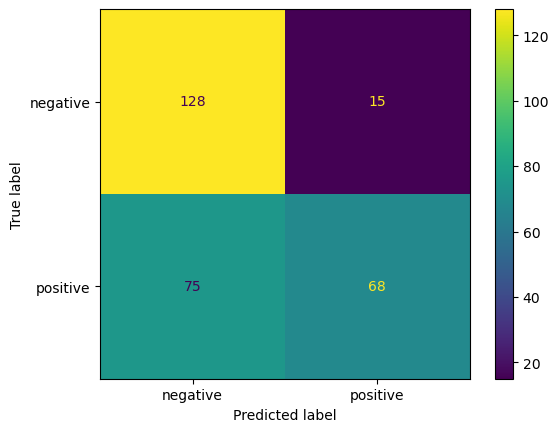

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Data Preprocesing
# Remove neutral data -  not enough data to train
song_lyrics_naive_bayes_df = song_lyrics_zero_shot_df[~(song_lyrics_zero_shot_df['predicted_label'] == "neutral")]

# Balance the dataset between postive and negative rows
song_lyrics_naive_bayes_neg_df = song_lyrics_zero_shot_df[(song_lyrics_zero_shot_df['predicted_label'] == "negative")]
song_lyrics_naive_bayes_neg_df = song_lyrics_naive_bayes_neg_df.sample(n=476,random_state=42)
song_lyrics_naive_bayes_pos_df = song_lyrics_zero_shot_df[(song_lyrics_zero_shot_df['predicted_label'] == "positive")]
song_lyrics_naive_bayes_df = pd.concat([song_lyrics_naive_bayes_pos_df,song_lyrics_naive_bayes_neg_df])

# Convert the text data into TF-IDF features
tfidf = TfidfVectorizer()

#Feature vector
X = tfidf.fit_transform(song_lyrics_naive_bayes_df['lyrics'])

#Print vector X
print("Number of samples: ", X.shape[0])
print("Number of words in lyric corpus: ", X.shape[1])

#Target vector
y = song_lyrics_naive_bayes_df['predicted_label']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=song_lyrics_naive_bayes_df['predicted_label'])

# Initialize the Naive Bayes classifier
nb = MultinomialNB()

# Train the model
nb.fit(X_train, y_train)

# Predict the labels on the test set
y_pred = nb.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Print the classification report
print(classification_report(y_test, y_pred))

# Print Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=nb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=nb.classes_)

disp.plot()
plt.show()

The Naive Bayes model makes correct predictions 69% of the time. The precision score (48%) suggests that the model has difficulty classifying lyrics that have a positive sentiment. This is confirmed by the confusion matrix, where 75 songs were incorrectly classified as negative. This leads to two reflections:

1. MultinomialNB assumes that features (words) are conditionally independent - in other words it does not capture context. This assumption does not hold as lyrics have strong dependencies. For example, the word "crazy" has negative connotations. However, within the lyric "Shine on you crazy diamond", it has positive overtones. Therefore, there is a high chance of incorrect classificationas the model.
2. As shown in the Zero-shot analysis boxplots, lyrics classed as negative tend to be *strongly* negative compared to positive. Therefore, perhaps it is easier for the MultinomialNB to identify, or default to, classing lyrics as negative.


### Chat GPT Prompt
TBC

### Model comparison using self-labelled data 

Aim here is to see how well large language models compare to supervised learning techniques with self-labelled data.

1. Read in labelled data of 62 songs
2. Classify text using (1) Multinomial NB and (2) Zero-shot classification
3. Compare results

In [ ]:
# Read labelled data
song_lyrics_positive_labelled_df = pd.read_csv('song_lyrics_positive_labelled.csv')
song_lyrics_negative_labelled_df = pd.read_csv('song_lyrics_negative_labelled.csv')

song_lyrics_labelled_df = pd.concat([song_lyrics_positive_labelled_df,song_lyrics_negative_labelled_df])

#### Multinomial NB

Note - may have to use the code below to build the original model, and then extend it to train the data.

Results using unseen data
Accuracy: 0.7903225806451613
Classification Report:
              precision    recall  f1-score   support

    negative       0.72      0.94      0.82        31
    positive       0.91      0.65      0.75        31

    accuracy                           0.79        62
   macro avg       0.82      0.79      0.79        62
weighted avg       0.82      0.79      0.79        62



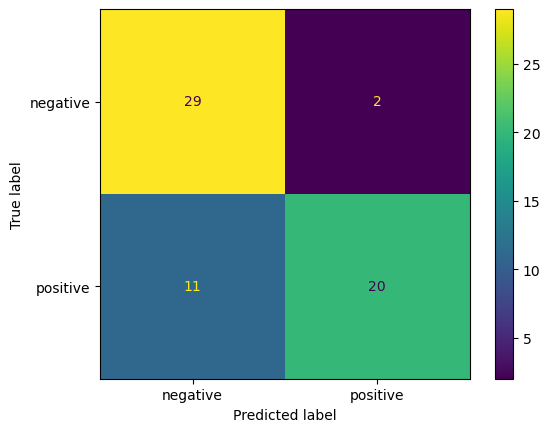

In [ ]:
# Multinomial NB
X_new = song_lyrics_naive_bayes_df['lyrics']
labels_new = song_lyrics_naive_bayes_df['predicted_label']

# Step 1: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_new, labels_new, test_size=0.3, random_state=42,stratify=song_lyrics_naive_bayes_df['predicted_label'])

# Step 2: Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Step 3: Train the Multinomial Naive Bayes model
model = MultinomialNB()
model.fit(X_train_vectorized, y_train)

# Step 4: Test the model on the test data
y_pred = model.predict(X_test_vectorized)

# Step 5: Evaluate the model's performance
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy}")
# print("Classification Report:")
# print(classification_report(y_test, y_pred))

# Step 6: Use the trained model to predict on unseen data
unseen_data = song_lyrics_labelled_df['lyrics']
unseen_actual = song_lyrics_labelled_df['actual_label']
unseen_data_vectorized = vectorizer.transform(unseen_data)
unseen_predictions = model.predict(unseen_data_vectorized)

accuracy = accuracy_score(unseen_actual, unseen_predictions)
print("Results using unseen data")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(unseen_actual, unseen_predictions))

# Print Confusion Matrix
cm = confusion_matrix(unseen_actual, unseen_predictions, labels=nb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=nb.classes_)

disp.plot()
plt.show()






#### Zero Shot Classification

TBC

In [ ]:
# Zero-Shot Classification

#Create dataset for zero shot results
song_lyrics_zero_shot_unseen_df = song_lyrics_labelled_df.copy()

#Sentiment labels
sentiment_labels = ["positive","neutral","negative"]

# Function to classify text and store results
def classify_lyrics(lyrics, candidate_labels):
    result = classifier(lyrics, candidate_labels)
    return result

# Apply classification to each row and store results
song_lyrics_zero_shot_unseen_df['classification'] = song_lyrics_zero_shot_unseen_df['lyrics'].apply(lambda x: classify_lyrics(x, sentiment_labels))

# Extract the scores for each label
for label in sentiment_labels:
    song_lyrics_zero_shot_unseen_df[label] = song_lyrics_zero_shot_unseen_df['classification'].apply(lambda x: x['scores'][x['labels'].index(label)])

# Extract the predicted label and score
song_lyrics_zero_shot_unseen_df['predicted_label'] = song_lyrics_zero_shot_unseen_df['classification'].apply(lambda x: x['labels'][0])
song_lyrics_zero_shot_unseen_df['predicted_score'] = song_lyrics_zero_shot_unseen_df['classification'].apply(lambda x: x['scores'][0])

# Drop the intermediate 'Classification' column
song_lyrics_zero_shot_unseen_df = song_lyrics_zero_shot_unseen_df.drop(columns=['classification'])




Zero-shot results using unseen data
Accuracy: 0.8709677419354839
Classification Report:
              precision    recall  f1-score   support

    negative       0.79      1.00      0.89        31
    positive       1.00      0.74      0.85        31

    accuracy                           0.87        62
   macro avg       0.90      0.87      0.87        62
weighted avg       0.90      0.87      0.87        62



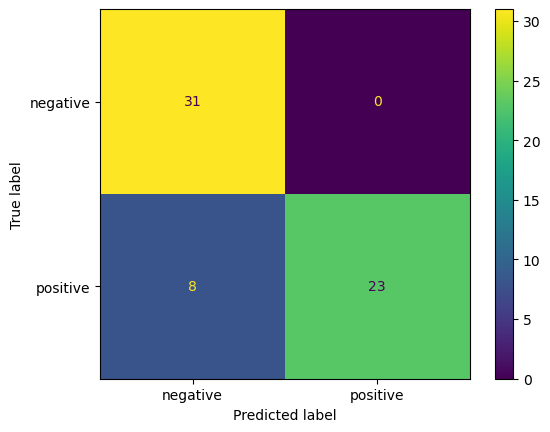

In [ ]:
#Confusion Matrix
accuracy = accuracy_score(song_lyrics_zero_shot_unseen_df['actual_label'], song_lyrics_zero_shot_unseen_df['predicted_label'])
print("Zero-shot results using unseen data")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(song_lyrics_zero_shot_unseen_df['actual_label'], song_lyrics_zero_shot_unseen_df['predicted_label']))

# Print Confusion Matrix
cm = confusion_matrix(song_lyrics_zero_shot_unseen_df['actual_label'], song_lyrics_zero_shot_unseen_df['predicted_label'], labels=nb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=nb.classes_)

disp.plot()
plt.show()